**Problem statement:** 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early

It accounts for 75% of skin cancer deaths

A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis

### **Importing Skin Cancer Data**
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
#Importing necessary libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### **I have mounted my google drive using the below code and Commented it out after its use case**

In [ ]:
## I have mounted my google drive using the below code and Commented it out after its use case
# from google.colab import drive
# drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

#### Checking the number of Images in Train & Test folder

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Dataset consists of **2357 images of malignant and benign** oncological diseases

2239 + 118 = 2357

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
#Setting up batch size, image height & weight

batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
## Validation split is 0.2 for 20%
## And subset is 'training'


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        validation_split=0.2,
        subset='training',
        seed=123,
        image_size=(img_height, img_width),
        batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
## Validation split is 0.2 for 20%
## And subset is 'validation'


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir_train,
        validation_split=0.2,
        subset='validation',
        seed=123,
        image_size=(img_height, img_width),
        batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

**Visualize single image from each on training data**

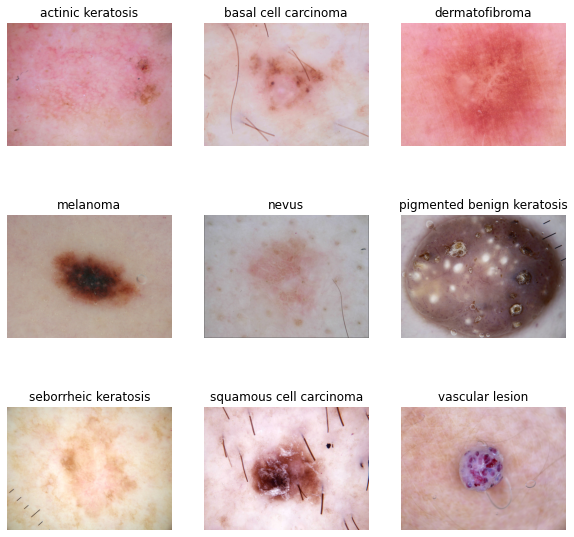

In [ ]:
### visualize single image from each on training data

### Directly from glob module to retrieve paths recursively from inside the directories/files
from glob import glob

### To read jpeg file from directory
import cv2 as cv

plt.figure(figsize=(10, 10))
for ind, key in enumerate(class_names):
  val = str(data_dir_train) + '/' + str(key)
  for jpgfile in glob(os.path.join(val, '*.jpg')):
    ax = plt.subplot(3, 3, int(ind) + 1)
    img = cv.imread(jpgfile)[:,:,::-1]
    plt.imshow(img)
    plt.title(key)
    plt.axis("off")
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
# From Stackoverflow answer
# tf.data builds a performance model of the input pipeline and runs an optimization algorithm
# to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch and shuffle
# Dataset.prefetch() overlaps data preprocessing and model execution while training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Rescaling
### Creating a model with 3 Convolutional layer & Max pooling
### Flatten after 3rd convolutional layer
### Dense layer & Final output layer

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

##### Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
##### SparseCategoricalCrossentropy computes the crossentropy loss between the labels and predictions

In [ ]:
### Adam optimization is a stochastic gradient descent method 
### that is based on adaptive estimation of first-order and second-order moments
### SparseCategoricalCrossentropy computes the crossentropy loss between the labels and predictions

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Train the model

In [ ]:
# Run model for 20 Epochs and save the details like accuracy, loss in history

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 413s 1s/step - loss: 1.9973 - accuracy: 0.2461 - val_loss: 1.8428 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.7595 - accuracy: 0.3711 - val_loss: 1.6986 - val_accuracy: 0.3960
Epoch 3/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6415 - accuracy: 0.4057 - val_loss: 1.6089 - val_accuracy: 0.4228
Epoch 4/20
56/56 [==============================] - 2s 44ms/step - loss: 1.5548 - accuracy: 0.4425 - val_loss: 1.5485 - val_accuracy: 0.4787
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.4514 - accuracy: 0.4905 - val_loss: 1.4819 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 2s 44ms/step - loss: 1.3595 - accuracy: 0.5145 - val_loss: 1.3753 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.2856 - accuracy: 0.5480 - val_loss: 1.4073 - val_accuracy: 0.5324
Epoch 8/20
56

##### Summary of all layers

In [ ]:
# View the summary of all layers

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0

### Visualizing training results

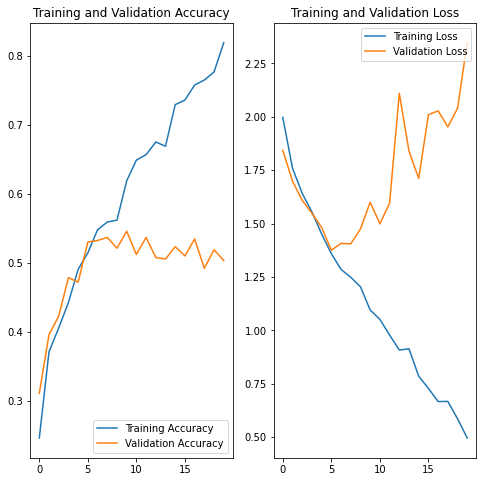

In [ ]:
# Visualising results from the model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### **Training & Validation**
###  - As the accuracy of training increases, the accuracy of validation becomes stable
###  - As the loss for validation increases, the loss of training decreased

### **From the above Observation, it's very clear that the model is Overfitting**

##### After we have analysed the model fit history for presence of underfit or overfit, we have to choose an appropriate data augumentation strategy. 

In [ ]:
# After we have analysed the model fit history for presence of underfit or overfit, we have to choose an appropriate data augumentation strategy. 

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### **Create an normalised image**

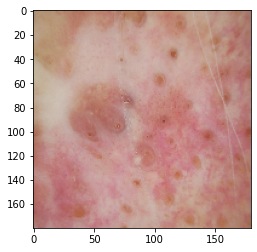

In [ ]:
#Create an normalised image

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

plt.imshow(first_image)

#### **Visualize how your augmentation strategy works for one instance of training image**

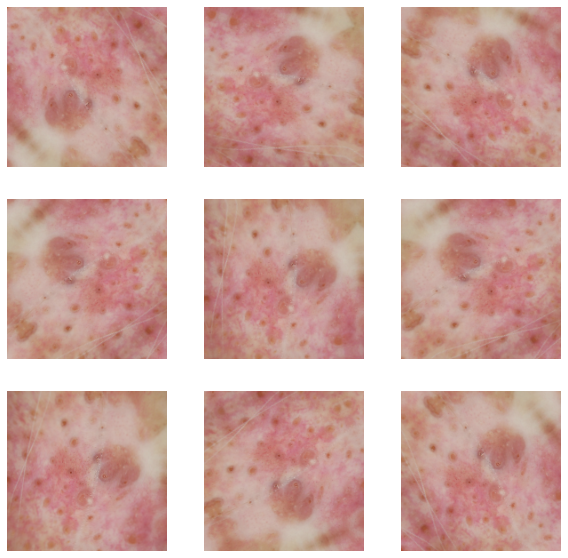

In [ ]:
# visualize how your augmentation strategy works for one instance of training image.

image = tf.expand_dims(first_image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
#Code to rescale
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

#Code to Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### **Function to resize, shuffle & augment data**

In [ ]:
# Function to resize, shuffle & augment data

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)
  
  # Shuffle only on the training set
  if shuffle:
   ds = ds.shuffle(1000)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Train & val Data to run model 2

train2_ds = prepare(train_ds, shuffle=True, augment=True)
val2_ds = prepare(val_ds)

### Added Dropout layer in the code **to avoid Overfitting**

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Compiling the model


##### Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
##### SparseCategoricalCrossentropy computes the crossentropy loss between the labels and predictions

In [ ]:
## Compile the model

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Training the model

In [ ]:
## train model for 20 epochs

history = model.fit(
  train2_ds,
  validation_data=val2_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 9s 130ms/step - loss: 1.9942 - accuracy: 0.2483 - val_loss: 1.8212 - val_accuracy: 0.3624
Epoch 2/20
56/56 [==============================] - 7s 121ms/step - loss: 1.7685 - accuracy: 0.3599 - val_loss: 1.6292 - val_accuracy: 0.4586
Epoch 3/20
56/56 [==============================] - 7s 116ms/step - loss: 1.6131 - accuracy: 0.4241 - val_loss: 1.5620 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 7s 113ms/step - loss: 1.5371 - accuracy: 0.4626 - val_loss: 1.5143 - val_accuracy: 0.4564
Epoch 5/20
56/56 [==============================] - 7s 115ms/step - loss: 1.4804 - accuracy: 0.4900 - val_loss: 1.3663 - val_accuracy: 0.5414
Epoch 6/20
56/56 [==============================] - 7s 114ms/step - loss: 1.3861 - accuracy: 0.5123 - val_loss: 1.4196 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 7s 119ms/step - loss: 1.3922 - accuracy: 0.5000 - val_loss: 1.3413 - val_accuracy: 0.5369
Epoch 

### Visualizing the results

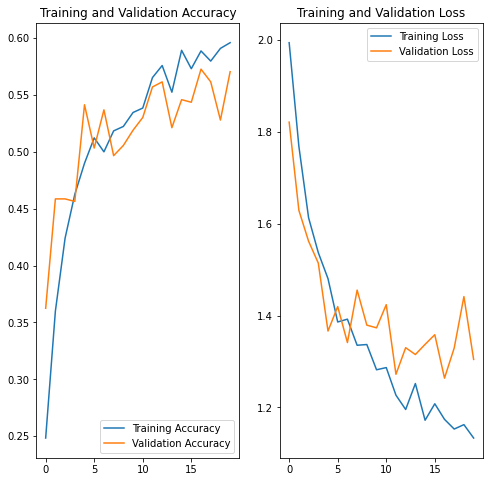

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**From the above results, it's clear that Training & Validation accuracy become very closer. Data augementation solved the Overfitting problem here**

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Create a dictionary
cls_dist = {}

# Check both train & validation dataset
# Calculate the number of images in each class
# Store it in 'cls_dist' dictionary

for ds in [train_ds, val_ds]:
  for image_batch, labels_batch in ds:
    # print(labels_batch)
    for i in labels_batch:
      # print(int(i))
      if int(i) in cls_dist.keys():
        cls_dist[int(i)] += 1
      else:
        cls_dist[int(i)] = 1

cls_dist

{0: 114, 1: 376, 2: 95, 3: 438, 4: 357, 5: 462, 6: 77, 7: 181, 8: 139}

#### Barplot to visualise the number of images in each class

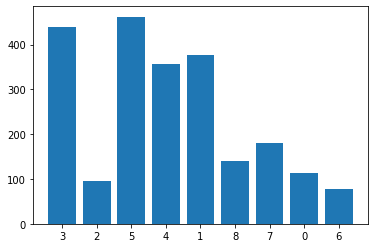

In [ ]:
#Barplot to visualise the number of images in each class

plt.bar(range(len(cls_dist)), list(cls_dist.values()), align='center')
plt.xticks(range(len(cls_dist)), list(cls_dist.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### **Seborrheic keratosis (Class 6) has the least number of samples 77**

#### - Which classes dominate the data in terms proportionate number of samples?
#### **Pigmented benign keratosis (Class 5) has the highest number of samples 462**

#### **To Improve the model, Let's Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
#Install Augmentor package

!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


#### Adding 500 samples per class to make sure that none of the classes are sparse

In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B1D44B10>: 100%|██████████| 500/500 [00:22<00:00, 22.09 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F77B30BC710>:   0%|          | 1/500 [00:00<01:11,  6.98 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B27A5F50>: 100%|██████████| 500/500 [00:23<00:00, 21.17 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B4A6DE10>: 100%|██████████| 500/500 [00:23<00:00, 21.54 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F781212CC50>: 100%|██████████| 500/500 [01:38<00:00,  5.09 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F77B3783550>: 100%|██████████| 500/500 [01:41<00:00,  4.93 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B27D2DD0>: 100%|██████████| 500/500 [00:22<00:00, 22.14 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F77B4CE8610>: 100%|██████████| 500/500 [00:50<00:00,  9.84 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F77B4A653D0>: 100%|██████████| 500/500 [00:23<00:00, 21.53 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F77B4CE8610>: 100%|██████████| 500/500 [00:22<00:00, 21.77 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# check the total count of augmented images

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
# path list for all the Augmented images

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027189.jpg_5f1f284c-d79b-4b41-b5d8-b35dd99641ed.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025046.jpg_cd3e3d56-c2f0-447c-8d69-b3fa83930c87.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030514.jpg_925bc7be-fc2d-4d9f-8e46-01611561a0c3.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025971.jpg_ee3931b5-a330-4fd4-a1cd-a31ddfee6c04.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imagin

In [ ]:
#Checking the length of path_list

len(path_list)

4500

In [ ]:
#Class name of each image

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [ ]:
#Checking the length of 'lesion_list_new'

len(lesion_list_new)

4500

In [ ]:
# Add 'path_list' & 'lesion_list_new' to create a dictionary 'dataframe_dict_new'

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
#check the dictionary

dataframe_dict_new

{'/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027189.jpg_5f1f284c-d79b-4b41-b5d8-b35dd99641ed.jpg': 'basal cell carcinoma',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025046.jpg_cd3e3d56-c2f0-447c-8d69-b3fa83930c87.jpg': 'basal cell carcinoma',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030514.jpg_925bc7be-fc2d-4d9f-8e46-01611561a0c3.jpg': 'basal cell carcinoma',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025971.jpg_ee3931b5-a330-4fd4-a1cd-a31ddfee6c04.jpg': 'basal cell carc

In [ ]:
# Convert 'dataframe_dict_new' dictionary into dataframe
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.head()

# new_df = original_df.append(df2)

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,basal cell carcinoma
1,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,basal cell carcinoma
2,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,basal cell carcinoma
3,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,basal cell carcinoma
4,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,basal cell carcinoma


In [ ]:
# checking the values in first row
print('Path: ', df2.loc[0]['Path'])
print('Label: ', df2.loc[0]['Label'])

Path:  /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027189.jpg_5f1f284c-d79b-4b41-b5d8-b35dd99641ed.jpg
Label:  basal cell carcinoma


In [ ]:
# Checking the value counts in each class of Augmented image 
df2['Label'].value_counts()

# new_df['Label'].value_counts()

squamous cell carcinoma       500
melanoma                      500
nevus                         500
actinic keratosis             500
dermatofibroma                500
pigmented benign keratosis    500
vascular lesion               500
seborrheic keratosis          500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
#Setting up batch_size, image height & weight

batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
# Train data after Augmentation

data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
# Validation data after Augmentation

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# From Stackoverflow answer
# tf.data builds a performance model of the input pipeline and runs an optimization algorithm
# to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch and shuffle
# Dataset.prefetch() overlaps data preprocessing and model execution while training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## Creating a model Model

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## Compile the model

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

#### **Todo:**  Train your model

In Problem statement, it's mentioned to run 30 epochs. So I'm running 30 instead of 50 epochs

In [ ]:
epochs = 30
# your model fit code

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 43s 87ms/step - loss: 1.7908 - accuracy: 0.3112 - val_loss: 1.5453 - val_accuracy: 0.4202
Epoch 2/30
169/169 [==============================] - 8s 45ms/step - loss: 1.4522 - accuracy: 0.4420 - val_loss: 1.4304 - val_accuracy: 0.4766
Epoch 3/30
169/169 [==============================] - 8s 45ms/step - loss: 1.3126 - accuracy: 0.4993 - val_loss: 1.2935 - val_accuracy: 0.5278
Epoch 4/30
169/169 [==============================] - 8s 44ms/step - loss: 1.1849 - accuracy: 0.5606 - val_loss: 1.1799 - val_accuracy: 0.5434
Epoch 5/30
169/169 [==============================] - 7s 44ms/step - loss: 1.0337 - accuracy: 0.6185 - val_loss: 0.9934 - val_accuracy: 0.6474
Epoch 6/30
169/169 [==============================] - 7s 44ms/step - loss: 0.8951 - accuracy: 0.6710 - val_loss: 1.0235 - val_accuracy: 0.6399
Epoch 7/30
169/169 [==============================] - 8s 46ms/step - loss: 0.7669 - accuracy: 0.7146 - val_loss: 0.8807 - val_accuracy: 0.690

#### **Todo:**  Visualize the model results

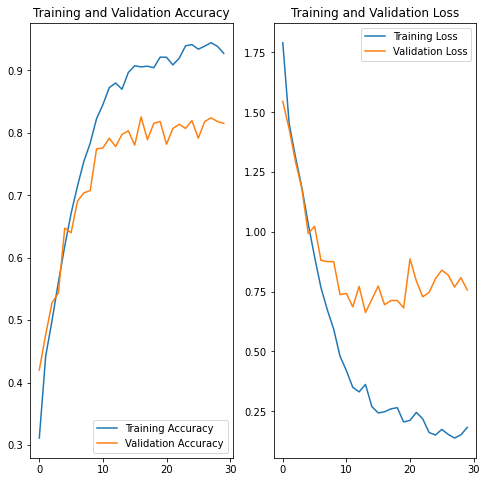

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**bold text**####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

#### **Accuracy has bee increased a lot when compared to the previous two models.**
#### **Overfitting issue in the earlier model is improved a little bit in the above model when compared to the first model**

#### **Working on Hyperparameter tuning may improve the model even more better**

